## Project: Reproducing "Growing Scale-Free Networks with Tunable Clustering" paper results

In this project, I reproduce all the results found in the paper **"Growing Scale-Free Networks with Tunable Clustering."** (Petter Holme and Beom Jun Kim)

The main idea is to introduce a tunable factor to modify the preferential attachment rule in a scale-free generative setting, to try to retrieve the characteristic seen in real networks, which is high clustering and the existence of hubs (high degree nodes.)

By the end of this notebook, I introduce a random failure process to compare robustness between a purely PA generated network (i.e. not including the tunable factor) with some modified networks (i.e. not diminishing clustering, but still following power-law degree distribution.)

In [2]:
%matplotlib inline
import networkx as nx
import numpy as np
import random
from ipywidgets import IntProgress
import matplotlib.pyplot as plt

from collections import Counter
from operator import itemgetter

First step: Defining some useful functions

In [3]:
#################### New Function 

def ba_wiring(n,links_to_add):
    # It receives the graph G, n as the number of new nodes, and m as the number of edges from a particular node
     
    m0 = random.randint(2,int(n/10))
    if links_to_add > m0:
        m0 = links_to_add

    m = m0 - 1
    
    G = nx.empty_graph(m0)
    #nx.draw_networkx(G)
    # Dictionary to acumulate the degree of nodes and to average over all degrees
    
    list_of_edges = []
    
    for nod in range(m0, n):
        
        
        degrees = dict(nx.degree(G))
        node_probs = {}

        if G.number_of_edges() == 0:
            for node in G.nodes():
                node_probs[node] = (float)(1 / G.number_of_nodes())
        else:
            for node in G.nodes():
                node_probs[node] = (float)(degrees[node] / sum(degrees.values()))


        # The following piece of code aims to attempt building the wiring process
        cumulative_prob = []
        acum = 0
        for node,prob in node_probs.items():
            temp = [node, acum+prob]
            cumulative_prob.append(temp)
            acum += prob

            
    # Now, we have to build the connections from each new node to the m-nodes they are to connect 
    # each node to a network
        nodes_target = []
        edges_added = []
        added_link = 0
        
        while added_link < links_to_add:
            cum_prob_per_node=0 # This aims to acumulate the probability over the whole ensemble
            rand = np.random.random()
            j = 0
            while(not(rand > cum_prob_per_node and rand < cumulative_prob[j][1])):
                cum_prob_per_node = cumulative_prob[j][1]
                j+=1
        
            target_node = cumulative_prob[j][0]

            if target_node in nodes_target:
                continue
            else: 
                nodes_target.append(target_node)
            G.add_edge(nod,target_node)
            edges_added.append((nod,target_node))
            added_link += 1
            
        list_of_edges.append(edges_added)
        
    return G, cumulative_prob, list_of_edges
   

In [38]:
n=2000
m=5
f = IntProgress(min=0, max=n, description='Running:') # instantiate the bar
display(f)
G=ba_wiring(200,8)

#G_test=nx.barabasi_albert_graph(n,m)


IntProgress(value=0, description='Running:', max=2000)

0.1430325729898996


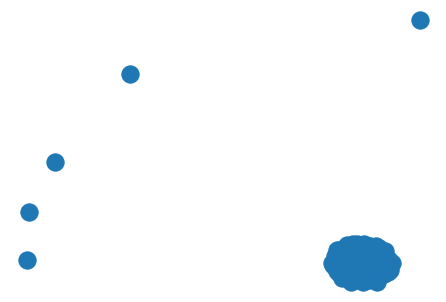

In [42]:
nx.draw(G[0])

print(nx.transitivity(G[0]))
#print(nx.transitivity(G_test))

In [6]:
nx.number_of_edges(G[0])

1448

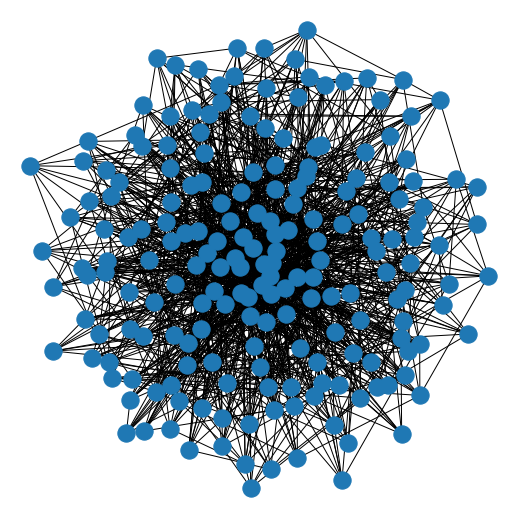

In [54]:
largest_cc = max(nx.connected_components(G[0]))
Gcc = G[0].subgraph(largest_cc)  

plt.figure(figsize=(7,7))
nx.draw(Gcc)

# PA + TF function

In [7]:
def ba_wiring_cluste(n,links_to_add,prob):
    # It receives the graph G, n as the number of new nodes, and m as the number of edges from a particular node
    
    m0 = links_to_add
    G = nx.empty_graph(m0)
       
    nod = m0
    
    f = IntProgress(min=0, max=n, description='Running:')
    display(f)
    
    while nod < n:
        
        repeated_nodes = []
        added_link = 0
        
        degrees = dict(nx.degree(G))
        node_probs = {}

        if G.number_of_edges() == 0:
            for node in G.nodes():
                node_probs[node] = (float)(1 / G.number_of_nodes())
        
        else:
            for node in G.nodes():
                node_probs[node] = (float)(degrees[node] / sum(degrees.values()))

        possible_targets = list(node_probs.keys())
        probability_target = list(node_probs.values())

        # We create this list to store all the target_nodes and to not repeat link assignment
        target = int(np.random.choice(possible_targets,1,p=probability_target))
       
        G.add_edge(nod,target)
        repeated_nodes.append(target)
        added_link = added_link + 1 
        
        while added_link<links_to_add:

            if random.random()<prob: # clustering step: add triangle
                neighbors=[neigh for neigh in G.neighbors(target) \
                               if not G.has_edge(nod,neigh) \
                               and not neigh==nod]
                if neighbors: # if there is a neighbor without a link
                    neigh=np.random.choice(neighbors)
                    G.add_edge(nod,neigh) # add triangle
                    repeated_nodes.append(neigh)
                    added_link=added_link+1
                    continue # go to top of while loop
            # else do preferential attachment step if above fails
            
            
            target = int(np.random.choice(possible_targets,1,p=probability_target))
            
            if target in repeated_nodes: # To ask if the target node has already been
                continue                # linked by the source node
                
            # If not before, we append this new edge from the source (nod) to the target.
            else:
                repeated_nodes.append(target)
                
            G.add_edge(nod,target)    
            added_link = added_link + 1
            
        f.value += 1
        nod += 1
    
    return G
   

# Brief comparison between Transitivity across networks

In [8]:
ns = [100,200,300,400,500,600,700,800,900,1000]
m = 3
p = 1

transitivity_bac = []
transitivity_plc = []
transitivity_ba = []

for idx in ns:
    G_test = ba_wiring_cluste(idx,m,p)
    G_ba = ba_wiring(idx,m)
    G_plc = nx.powerlaw_cluster_graph(idx,m,p)
    
    transitivity_ba.append(nx.transitivity(G_ba[0]))
    transitivity_bac.append(nx.transitivity(G_test))
    transitivity_plc.append(nx.transitivity(G_plc))

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=300)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=600)

IntProgress(value=0, description='Running:', max=700)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=900)

IntProgress(value=0, description='Running:', max=1000)

In [9]:
transitivity_bac

[0.2536127167630058,
 0.20471302587827092,
 0.20828258221680876,
 0.20890336590662323,
 0.22504626773596545,
 0.18477621966579896,
 0.19219620958751393,
 0.1842652058934643,
 0.1774349862703925,
 0.19145918688937913]

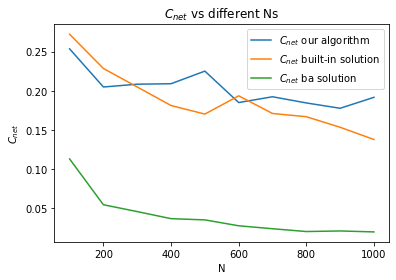

In [12]:
plt.plot(ns,transitivity_bac,label=r"$C_{net}$ our algorithm")
plt.plot(ns,transitivity_plc,label=r"$C_{net}$ built-in solution")
plt.plot(ns,transitivity_ba,label=r"$C_{net}$ ba solution")
plt.ylabel(r"$C_{net}$")
plt.xlabel("N")
plt.title(r"$C_{net}$ vs different Ns")
plt.legend()
plt.show()

# Functions to modify networks (random failure)

In [13]:
def random_deletion_links(G,array_to_delete):

    edges = list(G.edges()) 
    graph_modified = G.copy()
    
    if array_to_delete[0].size == 0:
        # No more links to delete.
        return graph_modified

    for index in np.nditer(array_to_delete):
        edge = edges[index]
        graph_modified.remove_edge(*edge)
    return graph_modified


def random_deletion_nodes(G,array_to_delete):

    nodes = list(G.nodes()) 
    graph_modified = G.copy()
    
    if array_to_delete[0].size == 0:
        # There's no more links to delete.
        return graph_modified

    for index in np.nditer(array_to_delete):
        node = nodes[index]
        graph_modified.remove_node(node)
    return graph_modified


def fraction_nodes_conncomp(G):
    total_nodes = G.number_of_nodes()
    
    # Retrieve largest connected component
    conn_graph = max(nx.connected_components(G),key=len)
    connected = G.subgraph(conn_graph)
    connected_size = connected.number_of_nodes()
    
    return connected_size/total_nodes

# Reproducing plots and results from the paper

# Figure 2. Degree distribution

In [14]:
ps = [0,0.15,0.3,0.45,0.6,0.75,0.9]

deg_seq = []
node_seq = []
for p in ps:
    G = ba_wiring_cluste(4000,3,p)
    deg_seq.append(nx.degree(G))

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:', max=4000)

In [15]:
#degree_sequence=sorted(nx.degree(G_test).values(),reverse=True) # degree sequence
graph_mt0 = dict(Counter(dict(deg_seq[0]).values()))
graph_mt015 = dict(Counter(dict(deg_seq[1]).values()))
graph_mt03 = dict(Counter(dict(deg_seq[2]).values()))
graph_mt045 = dict(Counter(dict(deg_seq[3]).values()))
graph_mt06 = dict(Counter(dict(deg_seq[4]).values()))
graph_mt075 = dict(Counter(dict(deg_seq[5]).values()))
graph_mt09 = dict(Counter(dict(deg_seq[6]).values()))

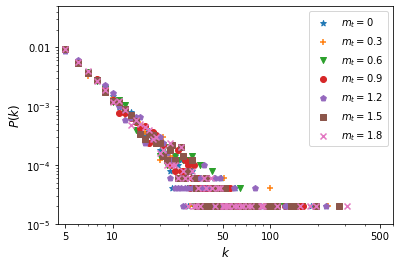

In [16]:
valuesmt0=[]
for value in graph_mt0.values():
     valuesmt0.append(value/50000)

valuesmt015=[]
for value in graph_mt015.values():
     valuesmt015.append(value/50000)

valuesmt03=[]
for value in graph_mt03.values():
     valuesmt03.append(value/50000)
        
valuesmt045=[]
for value in graph_mt045.values():
     valuesmt045.append(value/50000)
        
valuesmt06=[]
for value in graph_mt06.values():
     valuesmt06.append(value/50000)
        
valuesmt075=[]
for value in graph_mt075.values():
     valuesmt075.append(value/50000)

valuesmt09=[]
for value in graph_mt09.values():
     valuesmt09.append(value/50000)

        
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.001,0.05)
plt.xlim(4.5,600)
plt.scatter(graph_mt0.keys(),valuesmt0,marker="*",label=r"$m_{t} = 0$")
plt.scatter(graph_mt015.keys(),valuesmt015,marker="+",label=r"$m_{t} = 0.3$")
plt.scatter(graph_mt03.keys(),valuesmt03,marker="v",label=r"$m_{t} = 0.6$")
plt.scatter(graph_mt045.keys(),valuesmt045,marker="o",label=r"$m_{t} = 0.9$")
plt.scatter(graph_mt06.keys(),valuesmt06,marker="p",label=r"$m_{t} = 1.2$")
plt.scatter(graph_mt075.keys(),valuesmt075,marker="s",label=r"$m_{t} = 1.5$")
plt.scatter(graph_mt09.keys(),valuesmt09,marker="x",label=r"$m_{t} = 1.8$")

plt.xlabel(r"$k$",size=12)
plt.ylabel(r"$P(k)$",size=12)

plt.xticks([5, 10, 50, 100, 500], [str(5), str(10), str(50), str(100), str(500)])
plt.yticks([0.01, 0.001, 0.0001, 0.00001], [ str(0.01), r"$10^{-3}$", r"$10^{-4}$", r"$10^{-5}$"])
plt.legend()

# Figure 3.a $\langle \langle C \rangle \rangle$ vs $N$

$C = \frac{1}{n}\sum_{v \in G} c_v,\
\text{where n is the number of nodes in G} .$

In [17]:
nx.average_clustering(G)

0.5345129640340971

In [18]:
ps = [0,0.15,0.3,0.45,0.6,0.75,0.9]
N = [100,200,300,400,500,1000,1500,1800,2800,3500,4000]

In [19]:
avg_clust=[]

for p in ps:
    average_clustering = []
    for n in N:
        G = ba_wiring_cluste(n,3,p)
        average_clustering.append(nx.average_clustering(G))
    avg_clust.append(average_clustering)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=300)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=1000)

IntProgress(value=0, description='Running:', max=1500)

IntProgress(value=0, description='Running:', max=1800)

IntProgress(value=0, description='Running:', max=2800)

IntProgress(value=0, description='Running:', max=3500)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=300)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=1000)

IntProgress(value=0, description='Running:', max=1500)

IntProgress(value=0, description='Running:', max=1800)

IntProgress(value=0, description='Running:', max=2800)

IntProgress(value=0, description='Running:', max=3500)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=300)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=1000)

IntProgress(value=0, description='Running:', max=1500)

IntProgress(value=0, description='Running:', max=1800)

IntProgress(value=0, description='Running:', max=2800)

IntProgress(value=0, description='Running:', max=3500)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=300)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=1000)

IntProgress(value=0, description='Running:', max=1500)

IntProgress(value=0, description='Running:', max=1800)

IntProgress(value=0, description='Running:', max=2800)

IntProgress(value=0, description='Running:', max=3500)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=300)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=1000)

IntProgress(value=0, description='Running:', max=1500)

IntProgress(value=0, description='Running:', max=1800)

IntProgress(value=0, description='Running:', max=2800)

IntProgress(value=0, description='Running:', max=3500)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=300)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=1000)

IntProgress(value=0, description='Running:', max=1500)

IntProgress(value=0, description='Running:', max=1800)

IntProgress(value=0, description='Running:', max=2800)

IntProgress(value=0, description='Running:', max=3500)

IntProgress(value=0, description='Running:', max=4000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=300)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=500)

IntProgress(value=0, description='Running:', max=1000)

IntProgress(value=0, description='Running:', max=1500)

IntProgress(value=0, description='Running:', max=1800)

IntProgress(value=0, description='Running:', max=2800)

IntProgress(value=0, description='Running:', max=3500)

IntProgress(value=0, description='Running:', max=4000)

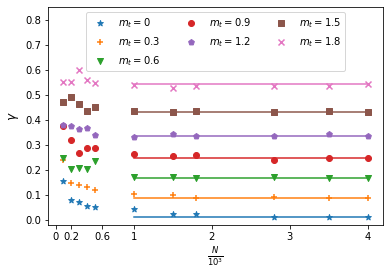

In [20]:
plt.scatter(N,avg_clust[0],marker="*",label=r"$m_{t} = 0$")
plt.scatter(N,avg_clust[1],marker="+",label=r"$m_{t} = 0.3$")
plt.scatter(N,avg_clust[2],marker="v",label=r"$m_{t} = 0.6$")
plt.scatter(N,avg_clust[3],marker="o",label=r"$m_{t} = 0.9$")
plt.scatter(N,avg_clust[4],marker="p",label=r"$m_{t} = 1.2$")
plt.scatter(N,avg_clust[5],marker="s",label=r"$m_{t} = 1.5$")
plt.scatter(N,avg_clust[6],marker="x",label=r"$m_{t} = 1.8$")

plt.plot([1000,4000],[avg_clust[0][10],avg_clust[0][10]])
plt.plot([1000,4000],[avg_clust[1][10],avg_clust[1][10]])
plt.plot([1000,4000],[avg_clust[2][10],avg_clust[2][10]])
plt.plot([1000,4000],[avg_clust[3][10],avg_clust[3][10]])
plt.plot([1000,4000],[avg_clust[4][10],avg_clust[4][10]])
plt.plot([1000,4000],[avg_clust[5][10],avg_clust[5][10]])
plt.plot([1000,4000],[avg_clust[6][10],avg_clust[6][10]])

plt.xticks([0,200,600,1000,2000,3000,4000],\
           [str(0), str(0.2),str(0.6), str(1), str(2), str(3),str(4)])

plt.ylim(-0.02,0.85)
plt.xlabel(r"$\frac{N}{10^{3}}$",size=12)
plt.ylabel(r"$\gamma$",size=12)

plt.legend(frameon=True,loc='upper center', bbox_to_anchor=(0.5,1), shadow=False, ncol=3)

# Figure 3.b $\langle \langle C \rangle \rangle$ and $C_{net}$ vs $m_{t}$

In [21]:
ps = [0,0.15,0.3,0.45,0.6,0.75,0.9]

transitivity = []
clustering_differentNs = []
graphs = []

for p in ps:
    G = ba_wiring_cluste(3000,3,p)
    clustering_differentNs.append(nx.average_clustering(G))
    transitivity.append(nx.transitivity(G))
    graphs.append(G)

IntProgress(value=0, description='Running:', max=3000)

IntProgress(value=0, description='Running:', max=3000)

IntProgress(value=0, description='Running:', max=3000)

IntProgress(value=0, description='Running:', max=3000)

IntProgress(value=0, description='Running:', max=3000)

IntProgress(value=0, description='Running:', max=3000)

IntProgress(value=0, description='Running:', max=3000)

In [22]:
mt = np.array(ps)
mt = mt*2

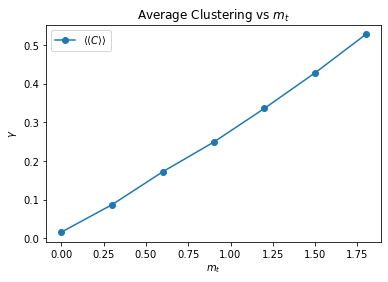

In [23]:
plt.plot(mt,clustering_differentNs,marker="o",label=r"$\langle \langle C \rangle \rangle$")
#plt.plot(mt,transitivity,marker="+",label=r"$C_{net}$")
plt.xlabel(r"$m_{t}$")
plt.ylabel(r"$\gamma$")
plt.title(r"Average Clustering vs $m_{t}$")
plt.legend()


# Figure 4. $\langle \langle d \rangle \rangle$ vs $m_{t}$

In [24]:
Collected_Path_Length_Data = []

for i in range(10):
    
    p_range = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
    n_range = [100, 200, 400, 800, 1600, 2000]
    m = 3

    Path_Lengths = []


    for p in p_range:

        for n in n_range:

            HK_model = ba_wiring_cluste(n,m,p)

            path = nx.average_shortest_path_length(HK_model)

            Path_Lengths.append(path)
            
    List_Split_PL = [Path_Lengths[i:i + 6] for i in range(0, len(Path_Lengths), 6)]
    
    Collected_Path_Length_Data.append(List_Split_PL)
    
Samples = [Collected_Path_Length_Data[i:i + 10] for i in range(0, len(Collected_Path_Length_Data), 10)]
SAMPLES = np.array(Samples)
SAMPLES = SAMPLES[0] # This line removes one of the unnecessary set of square brackets. 

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

IntProgress(value=0, description='Running:')

IntProgress(value=0, description='Running:', max=200)

IntProgress(value=0, description='Running:', max=400)

IntProgress(value=0, description='Running:', max=800)

IntProgress(value=0, description='Running:', max=1600)

IntProgress(value=0, description='Running:', max=2000)

In [25]:
ALL_mT_PathLength = []

for i in range(7):

    mT_Path_Len = []
    
    for j in range(10):
        
        #print(SAMPLES[j][i])
        mT_Path_Len.append(SAMPLES[j][i])
        
    ALL_mT_PathLength.append(np.mean(mT_Path_Len, axis=0))

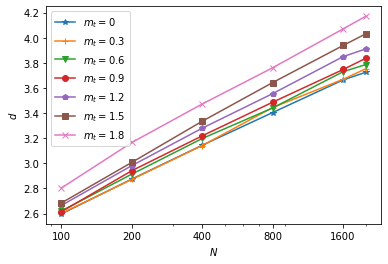

In [26]:
plt.plot(n_range, ALL_mT_PathLength[0], marker='*',label='$m_t = 0 $')
plt.plot(n_range, ALL_mT_PathLength[1], marker='+',label='$m_t = 0.3 $')
plt.plot(n_range, ALL_mT_PathLength[2], marker='v',label='$m_t = 0.6 $')
plt.plot(n_range, ALL_mT_PathLength[3], marker="o",label='$m_t = 0.9 $')
plt.plot(n_range, ALL_mT_PathLength[4], marker="p",label='$m_t = 1.2 $')
plt.plot(n_range, ALL_mT_PathLength[5], marker="s",label='$m_t = 1.5 $')
plt.plot(n_range, ALL_mT_PathLength[6], marker='x',label='$m_t = 1.8 $')
plt.xscale('log')
plt.xlabel('$N$')
plt.ylabel('$ d $')
plt.xticks([100, 200, 400, 800, 1600], [str(100), str(200), str(400), str(800), str(1600)])
plt.legend()


# Random node/link failure

# Node failure

In [27]:
probs_q = np.linspace(0.05,0.95,10) 

fraction_mt0_nod = []
fraction_mt09_nod = []
fraction_mt18_nod = []

# These graph come from section 3.b.
g_mt0 = graphs[0].copy() 
g_mt09 = graphs[3].copy()
g_mt18 = graphs[6].copy()

nodes_mt0 = g_mt0.number_of_nodes()
nodes_mt09 = g_mt09.number_of_nodes()
nodes_mt18 = g_mt18.number_of_nodes()

f = IntProgress(min=0, max=600, description='Running:')
display(f)

for i in range(600):
    fraction_mt0 = []
    fraction_mt09 = []
    fraction_mt18 = []
    
    for q in probs_q:

        node_prob_mt0 = np.random.rand(nodes_mt0)
        node_prob_mt09 = np.random.rand(nodes_mt09)
        node_prob_mt18 = np.random.rand(nodes_mt18)

        nodes_for_deletion_mt0 = np.where(node_prob_mt0 < q)
        nodes_for_deletion_mt09 = np.where(node_prob_mt09 < q)
        nodes_for_deletion_mt18 = np.where(node_prob_mt18 < q)


        Gmt0_modified = random_deletion_nodes(g_mt0, nodes_for_deletion_mt0)
        Gmt09_modified = random_deletion_nodes(g_mt09, nodes_for_deletion_mt09)
        Gmt18_modified = random_deletion_nodes(g_mt18, nodes_for_deletion_mt18)


        fraction_connected_mt0 = fraction_nodes_conncomp(Gmt0_modified)
        fraction_connected_mt09 = fraction_nodes_conncomp(Gmt09_modified)
        fraction_connected_mt18 = fraction_nodes_conncomp(Gmt18_modified)


        fraction_mt0.append(fraction_connected_mt0)
        fraction_mt09.append(fraction_connected_mt09)
        fraction_mt18.append(fraction_connected_mt18)
    
    f.value += 1
    fraction_mt0_nod.append(fraction_mt0)
    fraction_mt09_nod.append(fraction_mt09)
    fraction_mt18_nod.append(fraction_mt18)

IntProgress(value=0, description='Running:', max=600)

In [28]:
for i in range(len(fraction_mt0_nod)):
    fraction_mt0 = [np.average(fraction_mt0_nod[i][j]) for j in range(len(fraction_mt0_nod[i]))]

for i in range(len(fraction_mt09_nod)):
    fraction_mt09 = [np.average(fraction_mt09_nod[i][j]) for j in range(len(fraction_mt09_nod[i]))]

for i in range(len(fraction_mt18_nod)):
    fraction_mt18 = [np.average(fraction_mt18_nod[i][j]) for j in range(len(fraction_mt18_nod[i]))]
    

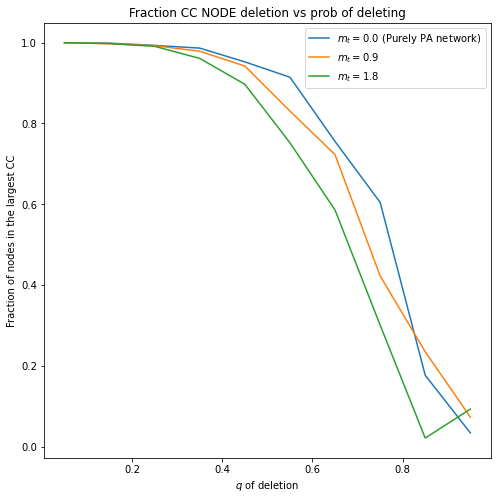

In [29]:

plt.figure(figsize=(8,8))
plt.plot(probs_q, fraction_mt0,label=r"$m_{t}=0.0$ (Purely PA network)")
plt.plot(probs_q, fraction_mt09,label=r"$m_{t}=0.9$")
plt.plot(probs_q, fraction_mt18,label=r"$m_{t}=1.8$")
plt.xlabel(r"$q$ of deletion")
plt.ylabel("Fraction of nodes in the largest CC")
plt.title("Fraction CC NODE deletion vs prob of deleting")
plt.legend()

# Sensitivity for larger network: $N = 40,000$

In [30]:
probs_q = np.linspace(0.05,0.95,10) 

fraction_mt01_nod = []
fraction_mt091_nod = []
fraction_mt181_nod = []

# These graph come from section 3.b.
g_mt01 = nx.powerlaw_cluster_graph(40000,3,0)
g_mt091 = nx.powerlaw_cluster_graph(40000,3,0.45)
g_mt181 = nx.powerlaw_cluster_graph(40000,3,0.9)

nodes_mt01 = g_mt01.number_of_nodes()
nodes_mt091 = g_mt091.number_of_nodes()
nodes_mt181 = g_mt181.number_of_nodes()

f = IntProgress(min=0, max=30, description='Running:')
display(f)

for i in range(30):
    fraction_mt01 = []
    fraction_mt091 = []
    fraction_mt181 = []
    
    for q in probs_q:

        node_prob_mt01 = np.random.rand(nodes_mt01)
        node_prob_mt091 = np.random.rand(nodes_mt091)
        node_prob_mt181 = np.random.rand(nodes_mt181)

        nodes_for_deletion_mt01 = np.where(node_prob_mt01 < q)
        nodes_for_deletion_mt091 = np.where(node_prob_mt091 < q)
        nodes_for_deletion_mt181 = np.where(node_prob_mt181 < q)


        Gmt01_modified = random_deletion_nodes(g_mt01, nodes_for_deletion_mt01)
        Gmt091_modified = random_deletion_nodes(g_mt091, nodes_for_deletion_mt091)
        Gmt181_modified = random_deletion_nodes(g_mt181, nodes_for_deletion_mt181)


        fraction_connected_mt01 = fraction_nodes_conncomp(Gmt01_modified)
        fraction_connected_mt091 = fraction_nodes_conncomp(Gmt091_modified)
        fraction_connected_mt181 = fraction_nodes_conncomp(Gmt181_modified)


        fraction_mt01.append(fraction_connected_mt01)
        fraction_mt091.append(fraction_connected_mt091)
        fraction_mt181.append(fraction_connected_mt181)
    
    f.value += 1
    fraction_mt01_nod.append(fraction_mt01)
    fraction_mt091_nod.append(fraction_mt091)
    fraction_mt181_nod.append(fraction_mt181)

IntProgress(value=0, description='Running:', max=30)

In [31]:
for i in range(len(fraction_mt01_nod)):
    fraction_mt01 = [np.average(fraction_mt01_nod[i][j]) for j in range(len(fraction_mt01_nod[i]))]

for i in range(len(fraction_mt091_nod)):
    fraction_mt091 = [np.average(fraction_mt091_nod[i][j]) for j in range(len(fraction_mt091_nod[i]))]

for i in range(len(fraction_mt181_nod)):
    fraction_mt181 = [np.average(fraction_mt181_nod[i][j]) for j in range(len(fraction_mt181_nod[i]))]

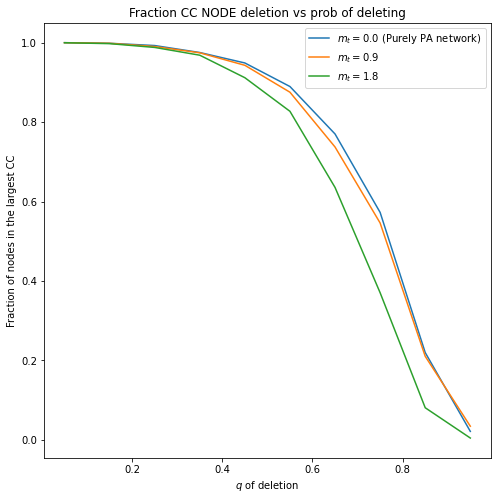

In [32]:
plt.figure(figsize=(8,8))
plt.plot(probs_q, fraction_mt01,label=r"$m_{t}=0.0$ (Purely PA network)")
plt.plot(probs_q, fraction_mt091,label=r"$m_{t}=0.9$")
plt.plot(probs_q, fraction_mt181,label=r"$m_{t}=1.8$")
plt.xlabel(r"$q$ of deletion")
plt.ylabel("Fraction of nodes in the largest CC")
plt.title("Fraction CC NODE deletion vs prob of deleting")
plt.legend()

# Trying link deletion

In [33]:
probs_q = np.linspace(0.05,0.99,10) 

fraction_mt0_edge = []
fraction_mt09_edge = []
fraction_mt18_edge = []

g_ed_mt0 = graphs[0].copy()
g_ed_mt09 = graphs[3].copy()
g_ed_mt18 = graphs[6].copy()

edges_mt0 = g_ed_mt0.number_of_edges()
edges_mt09 = g_ed_mt09.number_of_edges()
edges_mt18 = g_ed_mt18.number_of_edges()

f = IntProgress(min=0, max=600, description='Running:')
display(f)

for i in range(600):
    fraction_ed_mt0 = []
    fraction_ed_mt09 = []
    fraction_ed_mt18 = []
    
    for q in probs_q:

        edge_prob_mt0 = np.random.rand(edges_mt0)
        edge_prob_mt09 = np.random.rand(edges_mt09)
        edge_prob_mt18 = np.random.rand(edges_mt18)

        edges_for_deletion_mt0 = np.where(edge_prob_mt0 < q)
        edges_for_deletion_mt09 = np.where(edge_prob_mt09 < q)
        edges_for_deletion_mt18 = np.where(edge_prob_mt18 < q)


        Gmt0_edge_modified = random_deletion_links(g_ed_mt0, edges_for_deletion_mt0)
        Gmt09_edge_modified = random_deletion_links(g_ed_mt09, edges_for_deletion_mt09)
        Gmt18_edge_modified = random_deletion_links(g_ed_mt18, edges_for_deletion_mt18)


        fraction_connected_mt0 = fraction_nodes_conncomp(Gmt0_edge_modified)
        fraction_connected_mt09 = fraction_nodes_conncomp(Gmt09_edge_modified)
        fraction_connected_mt18 = fraction_nodes_conncomp(Gmt18_edge_modified)


        fraction_ed_mt0.append(fraction_connected_mt0)
        fraction_ed_mt09.append(fraction_connected_mt09)
        fraction_ed_mt18.append(fraction_connected_mt18)
    
    f.value += 1
    fraction_mt0_edge.append(fraction_ed_mt0)
    fraction_mt09_edge.append(fraction_ed_mt09)
    fraction_mt18_edge.append(fraction_ed_mt18)

IntProgress(value=0, description='Running:', max=600)

In [34]:
for i in range(len(fraction_mt0_edge)):
    fraction_mt0_ed = [np.average(fraction_mt0_edge[i][j]) for j in range(len(fraction_mt0_edge[i]))]

for i in range(len(fraction_mt09_edge)):
    fraction_mt09_ed = [np.average(fraction_mt09_edge[i][j]) for j in range(len(fraction_mt09_edge[i]))]

for i in range(len(fraction_mt18_edge)):
    fraction_mt18_ed = [np.average(fraction_mt18_edge[i][j]) for j in range(len(fraction_mt18_edge[i]))]
    

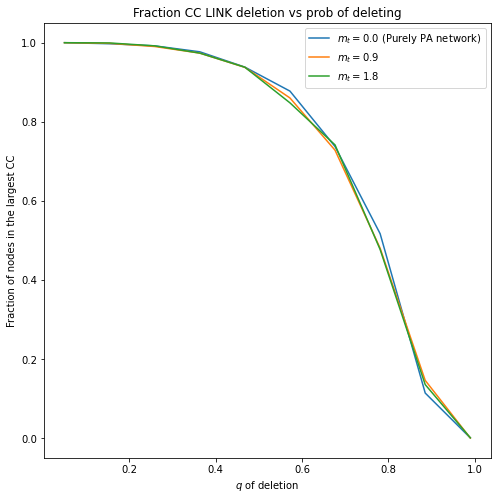

In [35]:
plt.figure(figsize=(8,8))
plt.plot(probs_q, fraction_mt0_ed,label=r"$m_{t}=0.0$ (Purely PA network)")
plt.plot(probs_q, fraction_mt09_ed,label=r"$m_{t}=0.9$")
plt.plot(probs_q, fraction_mt18_ed,label=r"$m_{t}=1.8$")
plt.xlabel(r"$q$ of deletion")
plt.ylabel("Fraction of nodes in the largest CC")

plt.title("Fraction CC LINK deletion vs prob of deleting")
plt.legend()